# <span style="color:orange">Quality Data Analysis - Project Work [FULL PROJECT] </span>
## Team 1

### Course Details:
- Academic Year: 2024-2025

### Project Details:
- Title: [ENTER PROJECT TITLE HERE]

### Team Members:
- Davide Chiecca
- Ginevra Carradori
- Linda Lovagnini
- Riccardo Caldara

### Instructor:
- Marco Luigi Giuseppe Grasso

# Instructions
- This is a template notebook for the project work.
- Please fill in the details above (team members, instructor, etc.)
## PHASE 1 - Report structure
Please use the following sections for your project report:
- **Introduction** [max 3500 characters including spaces]
    - Recap the project work framework and objective
    - Briefly summarize the overall methodology you used to model and analyse your data
    - Briefly summarize the state-of-the-art you analysed to support your study (if any).
- **Assumptions and preliminary data analysis** [max 5000 characters including spaces]
    - Clearly state and motivate all the assumptions your proposed methodology relies on; present and discuss any preliminary data analysis and visualization you applied on the data.
- **Proposed methodology** [max 10000 characters including spaces]
    - Synthetically describe, motivate and critically discuss your proposed statistical process monitoring approach. 
- **Results** [max 10000 characters including spaces]
    - Synthetically presents and discuss the results of your statistical process monitoring design. 

## PHASE 2 - Report structure
Please use the following sections for your project report:
- **Preliminary data analysis** [max 5000 characters including spaces]
    - Synthetically describe and discuss any preliminary data analysis and visualization applied on the new dataset.
- **Test of your proposed approach on new data** [max 5000 characters including spaces]
    - Synthetically presents and discuss the results you got applying to the new data your previously designed statistical process monitoring approach.
- **Discussion** [max 5000 characters including spaces]
    - Critically discuss your results In this Section you can also propose possible ways to tune or revise your previously designed method to enhance its defect detection performance. 

You can add code cells to any of the above sections to show your code or display images. Each block of code should be accompanied by a brief description of what it does (not counted in characters limits).

## Submission
- Name your notebook as `teamXX.ipynb` where `XX` is your team number.
- Submit your notebook together with the Dataframe as a ZIP file on Webeep by the deadline. The ZIP file name must clearly state the "TEAM NUMBER".

# PHASE 1 ------------------------------

# Introduction


Selective Laser Melting (SLM) is a layer-wise additive manufacturing technique known for its complexity and sensitivity to process conditions. The goal of this project is to design and test a statistical monitoring approach for spatially localizing process anomalies.

Our aim was to detect potential defects in areas of overheating or underheating using two approaches: a layer level analysis and row-wise spatial analysis. The first will look at the evolution of temperature between layers, while the second within layers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()
df.shape

(4512006, 12)

# Assumptions and preliminary data analysis

Initial data exploration involved visualizing the temporal evolution of temperature within each layer. This preliminary step revealed anomalous patterns, specifically identifying data points situated outside the physical boundaries of the laser-fabricated component.

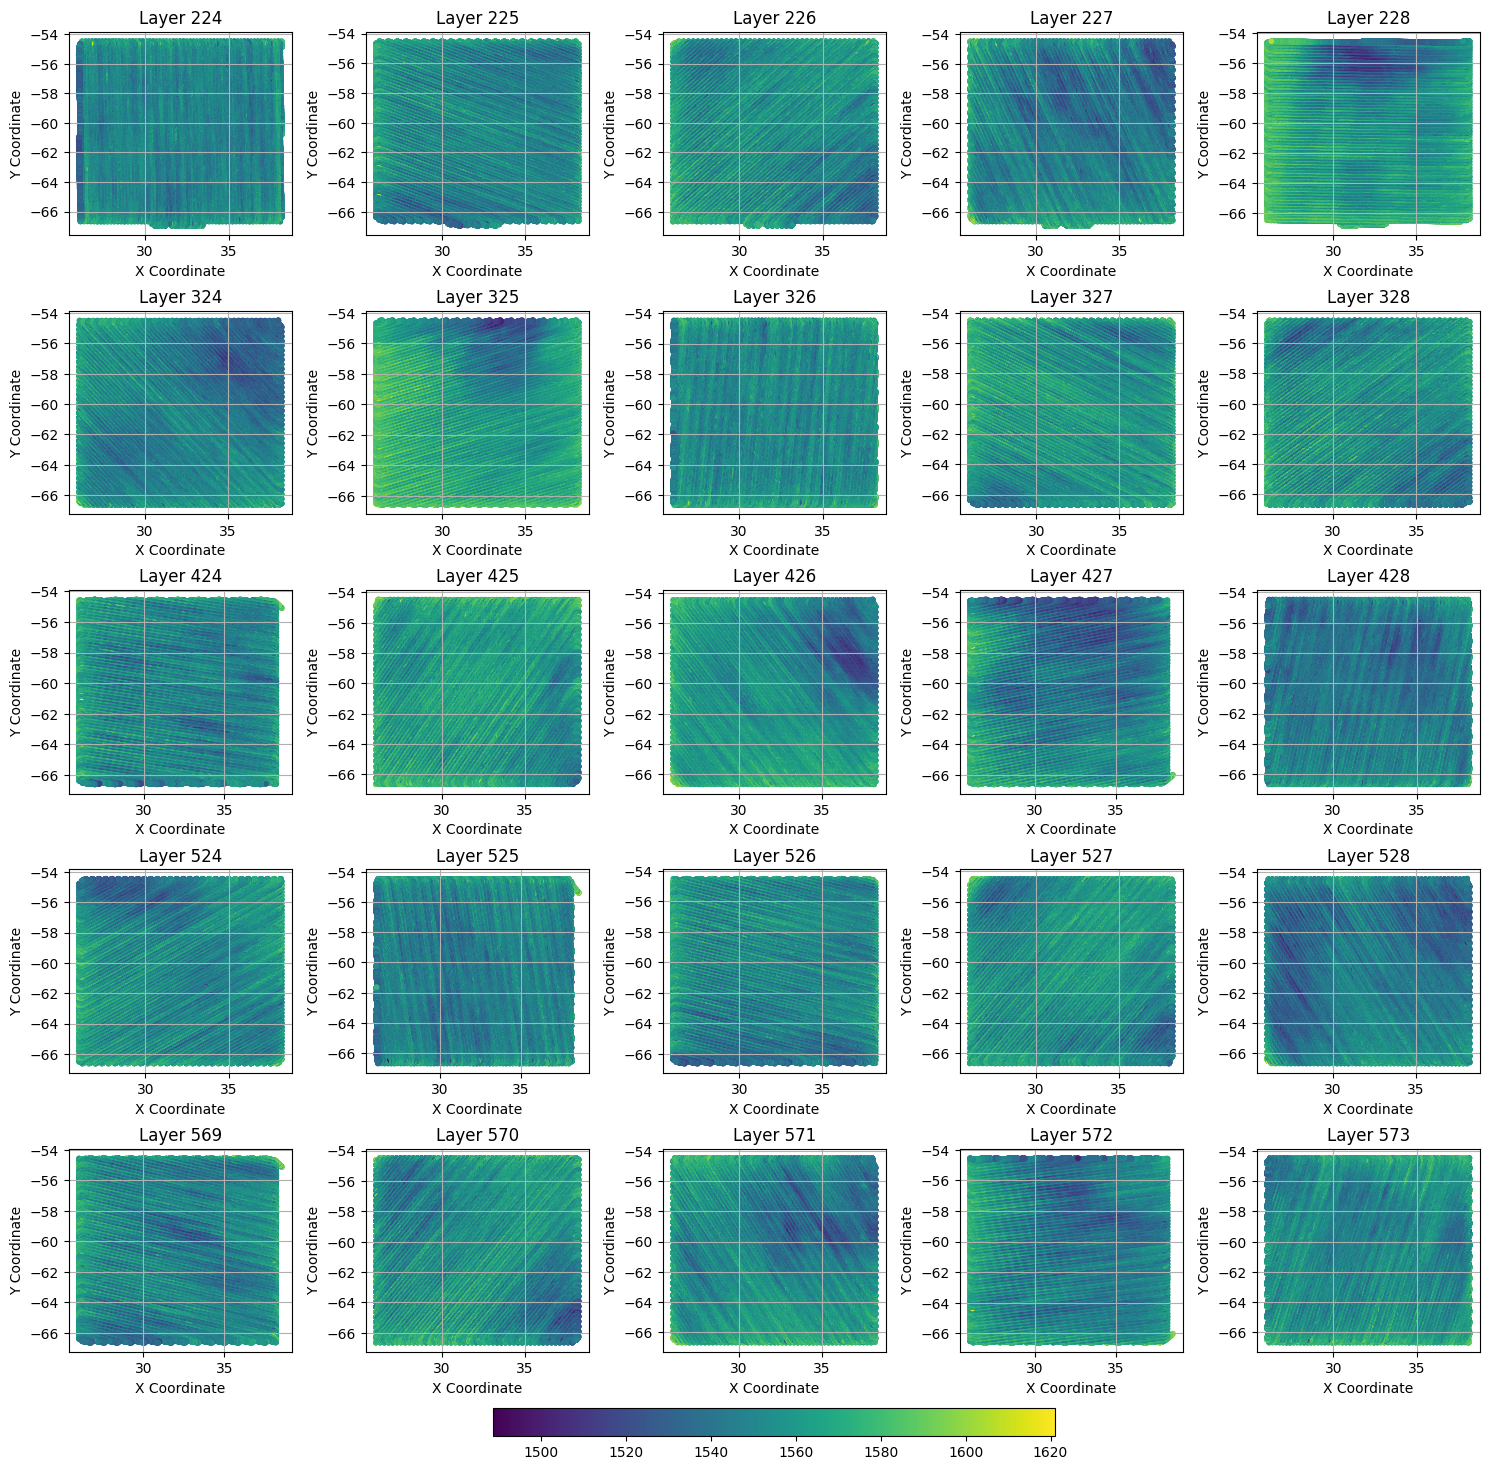

In [7]:
# Get unique layer IDs
unique_layer_ids = df['layer_id'].unique()

# Create a single figure with a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot each layer_id in a subplot
for i, layer_id in enumerate(unique_layer_ids):
    layer_data = df[df['layer_id'] == layer_id]
    scatter = axes[i].scatter(layer_data['x'], layer_data['y'], c=layer_data['temp'], cmap='viridis', s=10)
    axes[i].set_title(f'Layer {layer_id}')
    axes[i].set_xlabel('X Coordinate')
    axes[i].set_ylabel('Y Coordinate')
    axes[i].grid(True)

plt.tight_layout()
plt.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()

> Data visualization: path of the temperature on the space created by the variables x,y for each of the 25 layers.

Subsequently, we assessed the underlying data assumptions by examining a randomly selected single layer. This analysis indicated a significant autocorrelation between individual data points and their preceding lags. This strong temporal dependence was consistently observed across all layers, a phenomenon anticipated given the microsecond sampling frequency. Furthermore, the temperature data did not conform to a normal distribution.

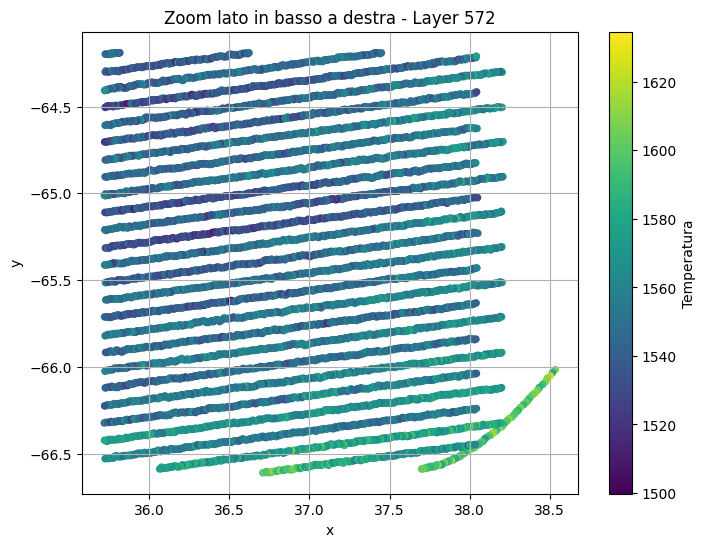

In [5]:
# Filtra i dati per il layer 572
layer_572 = df[df['layer_id'] == 572]

# Determina i limiti per lo zoom (in basso a destra)
# Prendiamo il 20% inferiore di y e il 20% superiore di x
x_min_zoom = layer_572['x'].quantile(0.8)
y_max_zoom = layer_572['y'].quantile(0.2)

zoom_data_572 = layer_572[(layer_572['x'] >= x_min_zoom) & (layer_572['y'] <= y_max_zoom)]

plt.figure(figsize=(8, 6))
sc2 = plt.scatter(zoom_data_572['x'], zoom_data_572['y'], c=zoom_data_572['temp'], cmap='viridis', s=20)
plt.colorbar(sc2, label='Temperatura')
plt.title('Zoom lato in basso a destra - Layer 572')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

> This chart is a zoom that regards the path of the temperature on the space created by the variables x,y for the layer_id 572, with a specific zoom on the area at the bottom-right part of the space created. The picture help us realizing that the laser collected also data outside the component, leading to a distortion of the dataset.

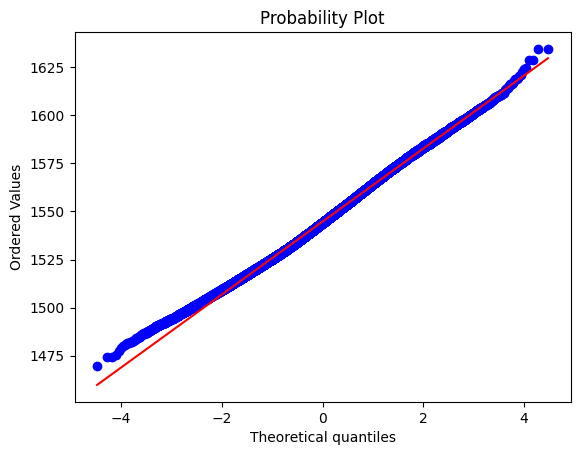

c:\Users\Utente\anaconda3\envs\qda_environment\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-wilk test statistic = 0.997
Shapiro-wilk test p-value = 0.000
Runs test statistic = -266.129
Runs test p-value = 0.000



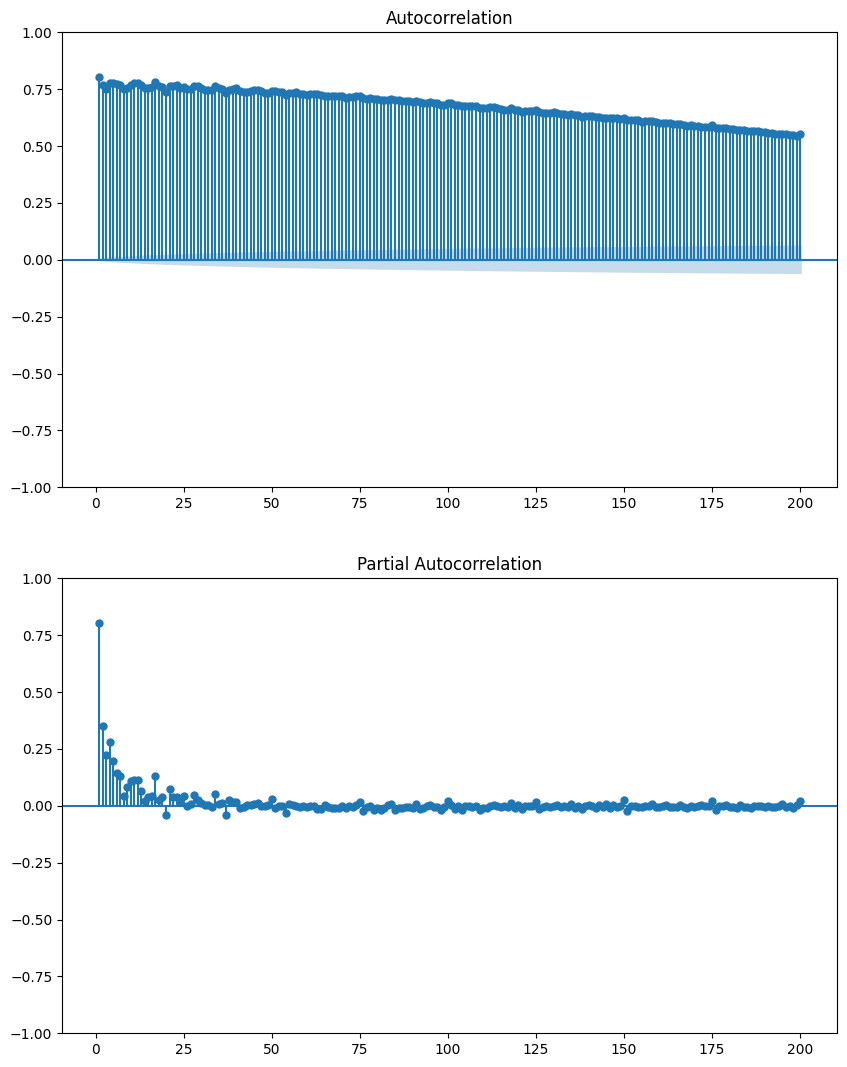

In [6]:
import qdatoolkit as qda
_ = qda.Assumptions(layer_572['temp']).normality()
_ = qda.Assumptions(layer_572['temp']).independence()

> The temperature in the layers is not normal. The ACF shows linear decay meaning non-stationarity in the process.

Spatial temperature patterns within individual layers were then investigated. Notably, the initial track identification (track_id) exhibited a higher average temperature compared to subsequent track_ids. Conversely, track_ids located centrally displayed intermediate temperature values, while those at the end presented lower temperature levels. This systematic variation suggested an inherent pattern within the data.

Then we've checked how the temperature varies inside a layer.

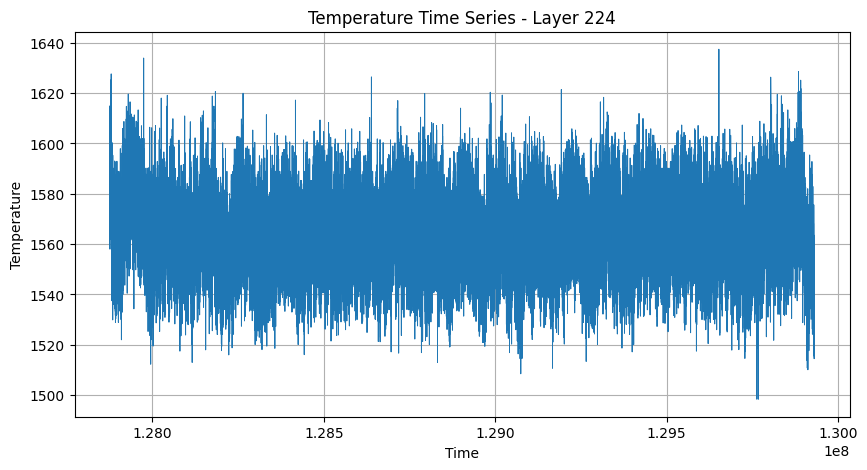

In [10]:
# Filter data for layer 224
layer_224 = df[df['layer_id'] == 224]

# Plot the temperature time series for layer 224
plt.figure(figsize=(10, 5))
plt.plot(layer_224['t'], layer_224['temp'], linewidth=0.7)
plt.title('Temperature Time Series - Layer 224')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

To mitigate the influence of data points collected at the layer boundaries, a cropping procedure was implemented for each layer. This was deemed necessary due to the varying spatial dimensions across layers and the inclusion of measurements outside the intended physical component, which could introduce distortions. To minimize the loss of information the size of the useful region was maximized adopting the following criteria:

$
x_{\text{range}} = (26.292,\ 38.089) \\
y_{\text{range}} = (-66.633,\ -54.62)
$

GINNI QUI

During the cropping process, challenges arose due to the differing inclinations of track_ids across layers. This resulted in the potential loss of data points at the boundaries of the cropped rectangular regions in certain instances. To address this, missing values within the resulting 2D temperature matrix were imputed using a two-step interpolation process: first vertically (along columns) and then horizontally (across rows). This approach aimed to generate a more complete grid of temperature values.

The rationale for employing bidirectional interpolation is rooted in the inherent spatial continuity of temperature data. This method avoids the potential biases or artifacts associated with simply discarding or zero-filling missing values. While interpolation can potentially smooth genuine variations or obscure outliers, it is important to note that the original data in each layer also contained missing points due to the aforementioned track_id inclination. Consequently, the distortion introduced by interpolation was considered to be primarily related to the smoothing of variations rather than the artificial creation of data.

Following the cropping stage, a consistent spatial grid was established across all layers. This step was crucial for enabling direct comparisons between corresponding regions in different layers. Initial attempts to utilize the original x,y coordinates as a common reference system proved unsuccessful due to misalignment between layers. Therefore, the creation of a standardized grid became necessary to ensure spatial consistency. This fundamental step allowed for subsequent uniform modeling of the layers, as both the cropped rectangular dimensions and the newly established grid system were consistent across all layers.

In [4]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [5]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_23376\1722546661.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_23376\1722546661.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


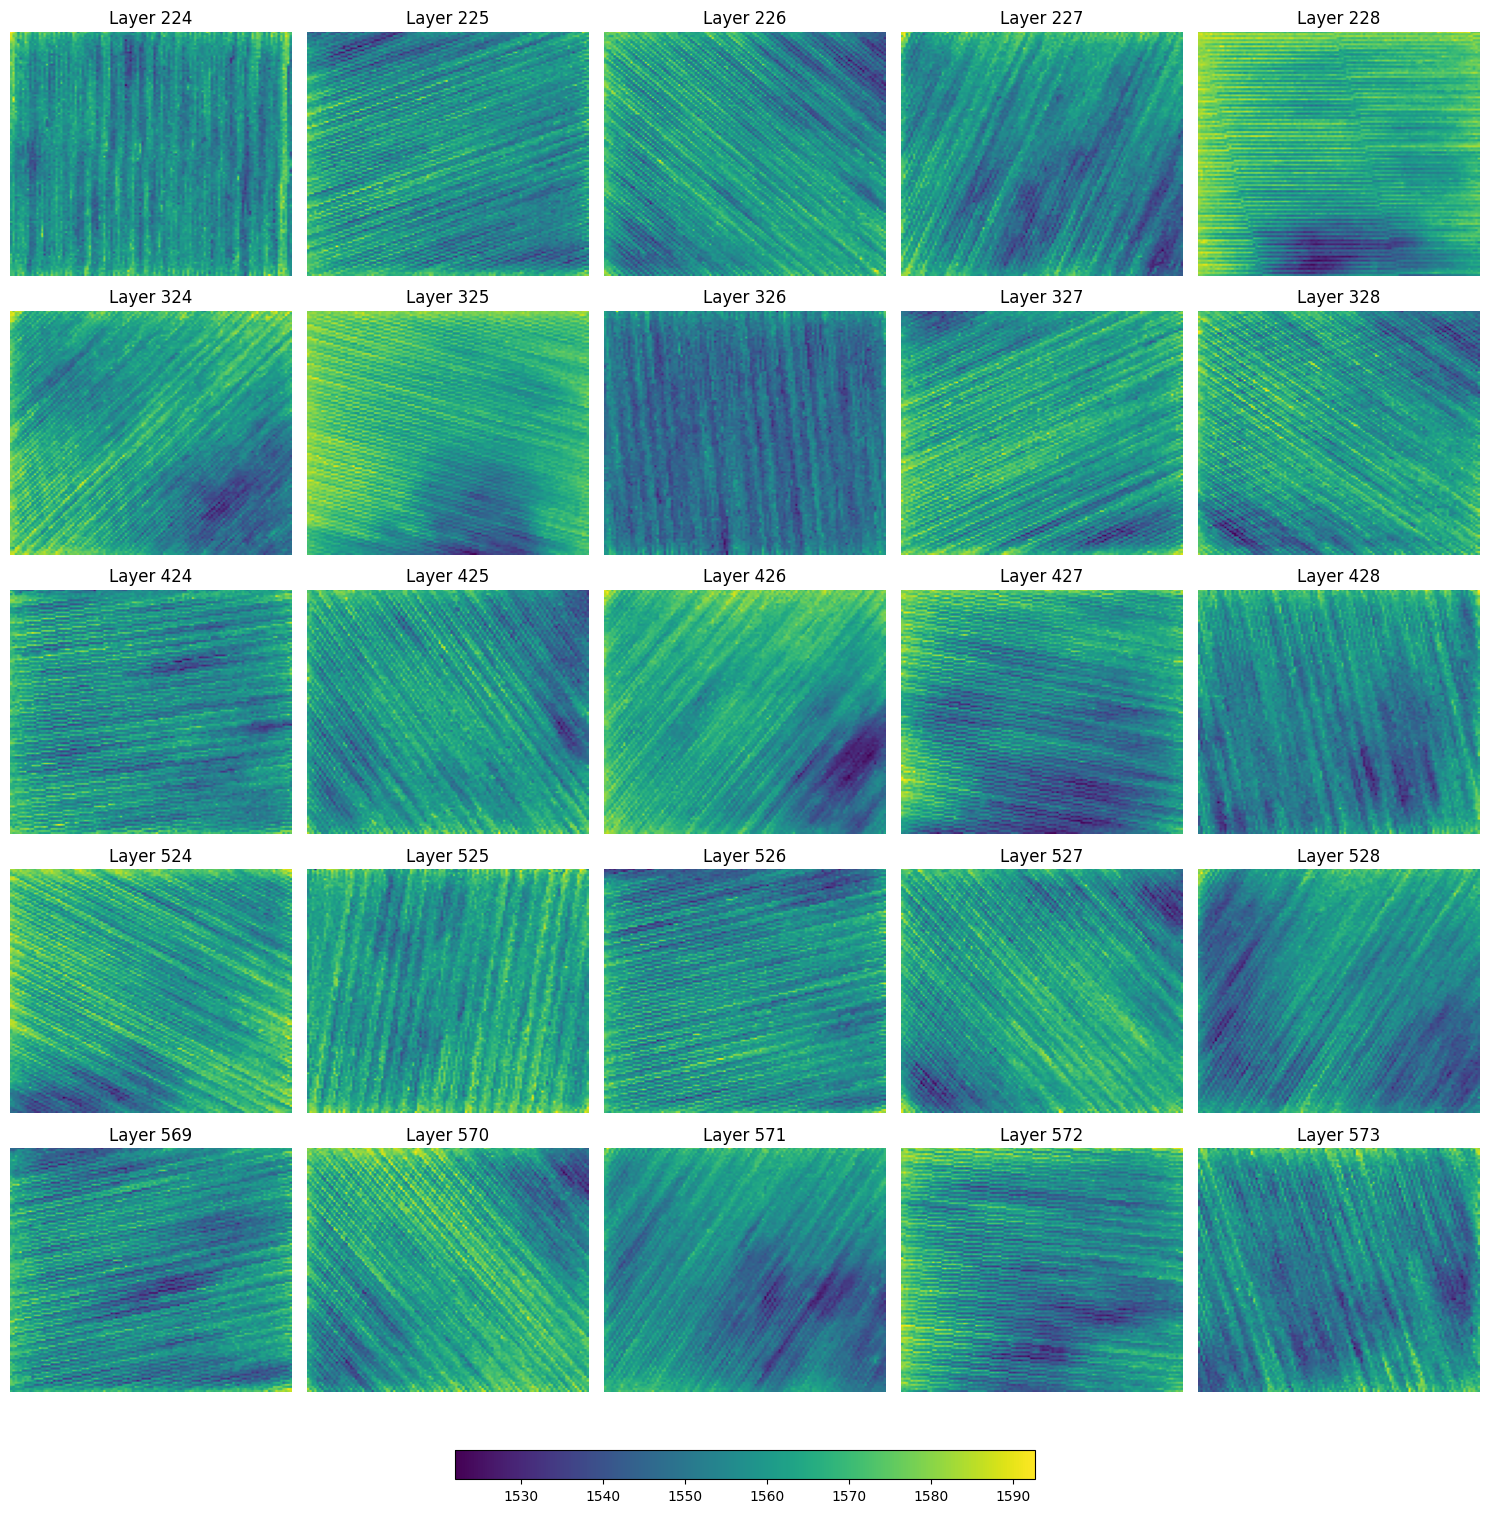

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, layer in enumerate(list_25l):
    im = axes[i].imshow(layer, aspect='auto', cmap='viridis')
    axes[i].set_title(f'Layer {layer_ids[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.04)
plt.show()

> Layers after cropping and resampling into the grid

# Proposed methodology

We evaluated and implemented two PCA unfolding strategies for reducing the high sampled data:
### 1. Layer-level analysis
Given $L$ the list of temperature matrices each with shape $(M, N)$ where, in our application, $M=N=120$, $L$ has shape $(25, 120, 120)$:
- Each layer is vectorized and treated as a row of size 120*120 = 14400
- PCA input matrix X ∈ ℝ(25 × 14400) where rows = layers, columns = pixels.
- PCA is applied across the 25 layers, with each pixel treated as a variable.
- Hotelling’s T² statistic is computed per layer, and a control chart is used to flag anomalous layers.
- A 99% UCL is calculated using the F-distribution.

This approach detects anomalous entire frames (e.g., hardware issues, spatter bursts, etc.).

### 2. Row-level analysis
Since all layers are comparable, PCA has been applied to a dataset containing all the layers.
Given $L$ the list of temperature matrices each with shape $(M, N)$ where, in our application, $M=N=120$, $L$ has shape $(25, 120, 120)$:
- Each row in the stacked dataset is an observation

# Results

# References (if any)

# PHASE 2 -----------------------------

# Preliminary data analysis

# Test of your proposed approach on new data

# Discussion